# Extract semantic similarity from gensim models

## Set up notebook

### Import libraries and set up paths

In [1]:
import os
import json
import pandas as pd
import numpy as np
import random
import scipy.io
import matplotlib.pyplot as plt
from scipy import ndimage
from gensim.models import KeyedVectors
import gensim.downloader as api
import seaborn as sns
from itertools import combinations
from nltk.corpus import wordnet as wn
from utils.utils import *

In [2]:
proj_dir = os.getcwd()
data_dir = os.path.join(proj_dir, 'data')
util_dir = os.path.join(proj_dir, 'utils')
analysis_dir = os.path.join(proj_dir, 'analysis')

### Read in data and models

In [27]:
# read dictionary mapping
with open(os.path.join(data_dir, 'namesToIds.json')) as json_file:
    namesToIds = json.load(json_file)
namesToIds['unlabeled'] = 0
idsToNames = {v: k for k, v in namesToIds.items()}

# read metadata
df = pd.read_csv('data/metadata.csv')
df['labels'] = df.labels.apply(eval)
df['instances'] = df.instances.apply(eval)

# remove unnecessary labels
df.labels.apply(lambda x:
                [x.remove(ele) for ele in ['unknown', 'unlabeled', 'wall', 'floor', 'ceiling'] if ele in x])

# get useful unique values for the possible names, scenes, and scene types
names = list(namesToIds.keys())
phrases = [name.split() for name in names]
scenes = sorted(df.scene.unique())
scene_types = sorted(df.scene_type.unique())

In [4]:
# import semantic embedding model
if not os.path.exists('models/fasttext-wiki-news-subwords-300.kv'):
    model = api.load('fasttext-wiki-news-subwords-300')
    model.save(f"models/fasttext-wiki-news-subwords-300.kv")
else:
    ft_300 = KeyedVectors.load(
        'models/fasttext-wiki-news-subwords-300.kv', mmap='r')

## Construct semantic similarity heatmaps for a single image

In [14]:
df['instances_labeless'] = df['instances'].apply(lambda arr: [n[:-2] for n in arr])

In [19]:
n = 839
label_sims = pd.DataFrame(index=df.instances_labeless[n], columns=df.instances_labeless[n])
for word1, word2 in combinations([label.split() for label in df.labels[n]], 2):
    label_sims.at[' '.join(word1), ' '.join(
        word2)] = ft_300.n_similarity(word1, word2)
label_sims = label_sims.fillna(0)

In [21]:
label_sims_long = pd.melt(label_sims.reset_index(),
                          id_vars=['index'],
                          value_vars=label_sims.columns,
                          var_name='label2',
                          value_name='similarity')
label_sims_long = label_sims_long.sort_values(by='similarity', ascending=False)
label_sims = label_sims + label_sims.T - np.diag(np.diag(label_sims))

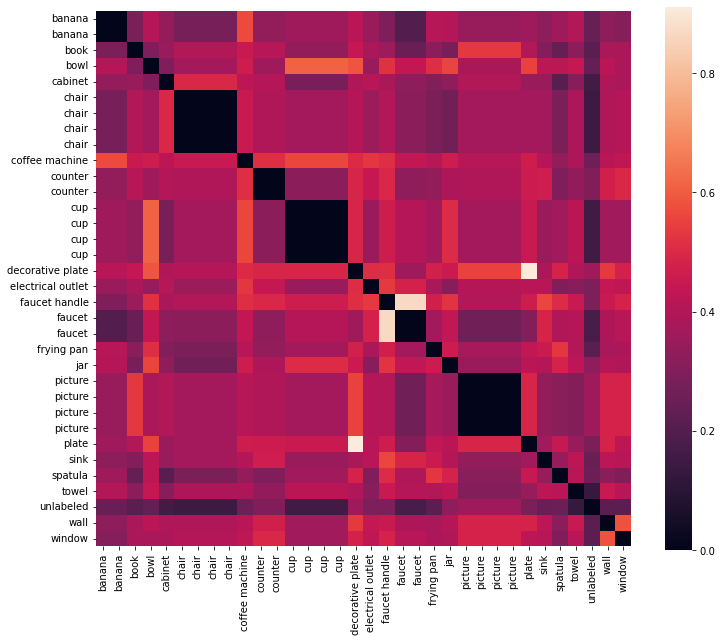

In [23]:
plt.figure(figsize=(12,10))
sns.heatmap(label_sims, square=True);

In [24]:
label_sims_clean = label_sims.drop(columns=['unlabeled'], index=['unlabeled'])
label_sims_clean = label_sims_clean.drop(columns=['wall', 'window'], index=['wall', 'window'])
label_sims_clean = ((label_sims_clean - np.unique(label_sims_clean.values.flatten())[1]) * 15) ** 1.2
np.fill_diagonal(label_sims_clean.values, 0)


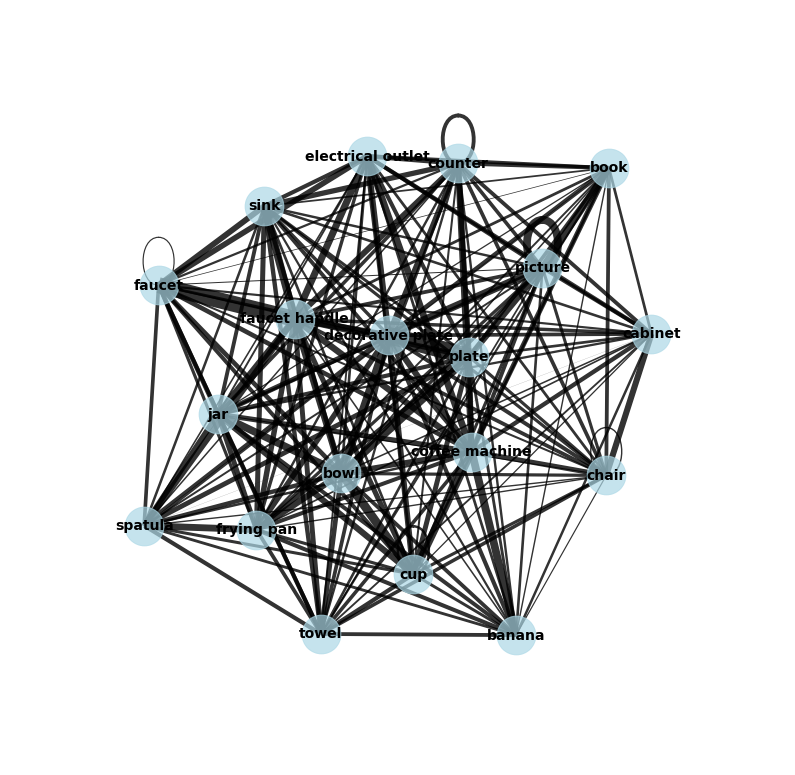

In [25]:
import networkx as nx
G = nx.Graph(label_sims_clean.values)

labels = label_sims_clean.columns.values
G = nx.relabel_nodes(G, dict(zip(range(len(labels)), labels)))

widths = nx.get_edge_attributes(G, 'weight')
nodelist = G.nodes()

plt.figure(figsize=(14, 14))
pos = nx.spring_layout(G, iterations=200, k=5)
nx.draw_networkx_nodes(G, pos,
                       nodelist=nodelist,
                       node_size=1500,
                       node_color='lightblue',
                       alpha=0.7)
nx.draw_networkx_edges(G, pos,
                       connectionstyle="arc3,rad=0.3",
                       edgelist=widths.keys(),
                       width=list(widths.values()),
                       edge_color=list(widths.values()),
                       edge_cmap=plt.cm.YlGn,
                       alpha=0.8)
nx.draw_networkx_labels(G, pos=pos,
                        labels=dict(zip(nodelist, nodelist)),
                        font_color='black',
                        font_weight='bold',
                        font_size=14)
plt.box(False)
plt.margins(x=0.2, y=0.2)
plt.show()

In [26]:
for i in wn.synsets(df.labels[0][0], pos=wn.NOUN):
    print(f'{i}: {i.definition()}')

Synset('book.n.01'): a written work or composition that has been published (printed on pages bound together)
Synset('book.n.02'): physical objects consisting of a number of pages bound together
Synset('record.n.05'): a compilation of the known facts regarding something or someone
Synset('script.n.01'): a written version of a play or other dramatic composition; used in preparing for a performance
Synset('ledger.n.01'): a record in which commercial accounts are recorded
Synset('book.n.06'): a collection of playing cards satisfying the rules of a card game
Synset('book.n.07'): a collection of rules or prescribed standards on the basis of which decisions are made
Synset('koran.n.01'): the sacred writings of Islam revealed by God to the prophet Muhammad during his life at Mecca and Medina
Synset('bible.n.01'): the sacred writings of the Christian religions
Synset('book.n.10'): a major division of a long written composition
Synset('book.n.11'): a number of sheets (ticket or stamps etc.) boun

In [9]:
# closer to 0 is more similiar
dog = wn.synset('dog.n.01')
cat = wn.synset('cat.n.01')
dog.path_similarity(cat)

0.2

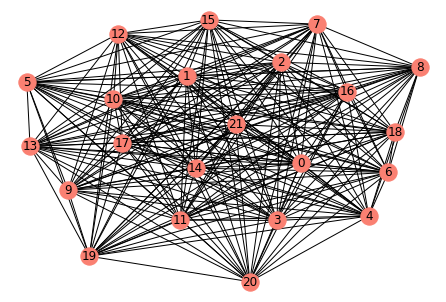